In [1]:
import numpy as np
import random
import math
import time
'''
数据集：伪造数据集（两个高斯分布混合）
数据集长度：1000
------------------------------
运行结果：
----------------------------
the Parameters set is:
alpha0:0.3, mu0:0.7, sigmod0:-2.0, alpha1:0.5, mu1:0.5, sigmod1:1.0
----------------------------
the Parameters predict is:
alpha0:0.4, mu0:0.6, sigmod0:-1.7, alpha1:0.7, mu1:0.7, sigmod1:0.9
----------------------------
'''

def loadData(mu0, sigma0, mu1, sigma1, alpha0, alpha1):
    '''
    初始化数据集
    这里通过服从高斯分布的随机函数来伪造数据集
    :param mu0: 高斯0的均值
    :param sigma0: 高斯0的方差
    :param mu1: 高斯1的均值
    :param sigma1: 高斯1的方差
    :param alpha0: 高斯0的系数
    :param alpha1: 高斯1的系数
    :return: 混合了两个高斯分布的数据
    '''
    # 定义数据集长度为1000
    length = 1000

    # 初始化第一个高斯分布，生成数据，数据长度为length * alpha系数，以此来
    # 满足alpha的作用
    data0 = np.random.normal(mu0, sigma0, int(length * alpha0))
    # 第二个高斯分布的数据
    data1 = np.random.normal(mu1, sigma1, int(length * alpha1))

    # 初始化总数据集
    # 两个高斯分布的数据混合后会放在该数据集中返回
    dataSet = []
    # 将第一个数据集的内容添加进去
    dataSet.extend(data0)
    # 添加第二个数据集的数据
    dataSet.extend(data1)
    # 对总的数据集进行打乱（其实不打乱也没事，只不过打乱一下直观上让人感觉已经混合了
    # 读者可以将下面这句话屏蔽以后看看效果是否有差别）
    random.shuffle(dataSet)

    #返回伪造好的数据集
    return dataSet

In [2]:
# 高斯分布公式，没有什么特殊的
def calcGauss(dataSetArr, mu, sigmod):
    '''
    根据高斯密度函数计算值
    依据：“9.3.1 高斯混合模型” 式9.25
    注：在公式中y是一个实数，但是在EM算法中(见算法9.2的E步)，需要对每个j
    都求一次yjk，在本实例中有1000个可观测数据，因此需要计算1000次。考虑到
    在E步时进行1000次高斯计算，程序上比较不简洁，因此这里的y是向量，在numpy
    的exp中如果exp内部值为向量，则对向量中每个值进行exp，输出仍是向量的形式。
    所以使用向量的形式1次计算即可将所有计算结果得出，程序上较为简洁
    
    :param dataSetArr: 可观测数据集
    :param mu: 均值
    :param sigmod: 方差
    :return: 整个可观测数据集的高斯分布密度（向量形式）
    '''
    # 计算过程就是依据式9.25写的，没有别的花样
    result = (1 / (math.sqrt(2*math.pi)*sigmod**2)) * np.exp(-1 * (dataSetArr-mu) * (dataSetArr-mu) / (2*sigmod**2))
    # 返回结果
    return result


def E_step(dataSetArr, alpha0, mu0, sigmod0, alpha1, mu1, sigmod1):
    '''
    EM算法中的E步
    依据当前模型参数，计算分模型k对观数据y的响应度
    :param dataSetArr: 可观测数据y
    :param alpha0: 高斯模型0的系数
    :param mu0: 高斯模型0的均值
    :param sigmod0: 高斯模型0的方差
    :param alpha1: 高斯模型1的系数
    :param mu1: 高斯模型1的均值
    :param sigmod1: 高斯模型1的方差
    :return: 两个模型各自的响应度
    '''
    # 计算y0的响应度
    # 先计算模型0的响应度的分子
    gamma0 = alpha0 * calcGauss(dataSetArr, mu0, sigmod0)
    #print("gamma0=",gamma0.shape) # 1000, 维向量
    # 模型1响应度的分子
    gamma1 = alpha1 * calcGauss(dataSetArr, mu1, sigmod1)

    # 两者相加为E步中的分布
    sum = gamma0 + gamma1
    # 各自相除，得到两个模型的响应度
    gamma0 = gamma0 / sum
    gamma1 = gamma1 / sum

    # 返回两个模型响应度
    return gamma0, gamma1

def M_step(muo, mu1, gamma0, gamma1, dataSetArr):
    # 依据算法9.2计算各个值
    # 这里没什么花样，对照书本公式看看这里就好了
    
    # np.dot 点积：[1,2] [2,3] = [2,6]
    mu0_new = np.dot(gamma0, dataSetArr) / np.sum(gamma0)
    mu1_new = np.dot(gamma1, dataSetArr) / np.sum(gamma1)

    # math.sqrt  平方根 
    sigmod0_new = math.sqrt(np.dot(gamma0, (dataSetArr - muo)**2) / np.sum(gamma0))
    sigmod1_new = math.sqrt(np.dot(gamma1, (dataSetArr - mu1)**2) / np.sum(gamma1))

    alpha0_new = np.sum(gamma0) / len(gamma0)
    alpha1_new = np.sum(gamma1) / len(gamma1)

    # 将更新的值返回
    return mu0_new, mu1_new, sigmod0_new, sigmod1_new, alpha0_new, alpha1_new


## 训练主函数
def EM_Train(dataSetList, iter=500):
    '''
    根据EM算法进行参数估计
    算法依据“9.3.2 高斯混合模型参数估计的EM算法” 算法9.2
    :param dataSetList:数据集（可观测数据）
    :param iter: 迭代次数
    :return: 估计的参数
    '''
    # 将可观测数据y转换为数组形式，主要是为了方便后续运算
    dataSetArr = np.array(dataSetList)

    # 步骤1：对参数取初值，开始迭代
    alpha0 = 0.5
    mu0 = 0
    sigmod0 = 1
    alpha1 = 0.5
    mu1 = 1
    sigmod1 = 1

    # 开始迭代
    step = 0
    while (step < iter):
        # 每次进入一次迭代后迭代次数加1
        step += 1
        # 步骤2：E步：依据当前模型参数，计算分模型k对观测数据y的响应度
        gamma0, gamma1 = E_step(dataSetArr, alpha0, mu0, sigmod0, alpha1, mu1, sigmod1)
        # 步骤3：M步
        mu0, mu1, sigmod0, sigmod1, alpha0, alpha1 = M_step(mu0, mu1, gamma0, gamma1, dataSetArr)

    # 迭代结束后将更新后的各参数返回
    return alpha0, mu0, sigmod0, alpha1, mu1, sigmod1

In [3]:
if __name__ == '__main__':
    start = time.time()

    # 设置两个高斯模型进行混合，这里是初始化两个模型各自的参数
    # 见“9.3 EM算法在高斯混合模型学习中的应用”
    # alpha是“9.3.1 高斯混合模型” 定义9.2中的系数α
    # mu0是均值μ
    # sigmod是方差σ
    # 在设置上两个alpha的和必须为1，其他没有什么具体要求，符合高斯定义就可以
    
    alpha0 = 0.3  # 系数α
    mu0 = -2  # 均值μ
    sigmod0 = 0.5  # 方差σ

    alpha1 = 0.7  # 系数α
    mu1 = 0.5  # 均值μ
    sigmod1 = 1  # 方差σ

    # 初始化数据集
    dataSetList = loadData(mu0, sigmod0, mu1, sigmod1, alpha0, alpha1)

    #打印设置的参数
    print('---------------------------')
    print('the Parameters set is:')
    print('alpha0:%.1f, mu0:%.1f, sigmod0:%.1f, alpha1:%.1f, mu1:%.1f, sigmod1:%.1f' % (
        alpha0, alpha1, mu0, mu1, sigmod0, sigmod1
    ))

    # 开始EM算法，进行参数估计
    alpha0, mu0, sigmod0, alpha1, mu1, sigmod1 = EM_Train(dataSetList)

    # 打印参数预测结果
    print('----------------------------')
    print('the Parameters predict is:')
    print('alpha0:%.1f, mu0:%.1f, sigmod0:%.1f, alpha1:%.1f, mu1:%.1f, sigmod1:%.1f' % (
        alpha0, alpha1, mu0, mu1, sigmod0, sigmod1
    ))

    # 打印时间
    print('----------------------------')
    print('time span:', time.time() - start)

---------------------------
the Parameters set is:
alpha0:0.3, mu0:0.7, sigmod0:-2.0, alpha1:0.5, mu1:0.5, sigmod1:1.0
----------------------------
the Parameters predict is:
alpha0:0.4, mu0:0.6, sigmod0:-1.8, alpha1:0.7, mu1:0.6, sigmod1:0.9
----------------------------
time span: 0.07599353790283203


In [4]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 
#生成随机数据，4个高斯模型
def generate_data(sigma,N,mu1,mu2,mu3,mu4,alpha):
    global X                  #可观测数据集
    X = np.zeros((N, 2))       # 初始化X，2行N列。2维数据，N个样本
    X=np.matrix(X)
    global mu                 #随机初始化mu1，mu2，mu3，mu4
    mu = np.random.random((4,2))
    mu=np.matrix(mu)
    global excep              #期望第i个样本属于第j个模型的概率的期望
    excep=np.zeros((N,4))
    global alpha_             #初始化混合项系数
    alpha_=[0.25,0.25,0.25,0.25]
    for i in range(N):
        if np.random.random(1) < 0.1:  # 生成0-1之间随机数
            X[i,:]  = np.random.multivariate_normal(mu1, sigma, 1)     #用第一个高斯模型生成2维数据
        elif 0.1 <= np.random.random(1) < 0.3:
            X[i,:] = np.random.multivariate_normal(mu2, sigma, 1)      #用第二个高斯模型生成2维数据
        elif 0.3 <= np.random.random(1) < 0.6:
            X[i,:] = np.random.multivariate_normal(mu3, sigma, 1)      #用第三个高斯模型生成2维数据
        else:
            X[i,:] = np.random.multivariate_normal(mu4, sigma, 1)      #用第四个高斯模型生成2维数据
 
    print("可观测数据：\n",X)       #输出可观测样本
    print("初始化的mu1，mu2，mu3，mu4：",mu)      #输出初始化的mu


# E 期望
#  \hat{\gamma_{jk}}
def e_step(sigma,k,N):
    global X
    global mu
    global excep
    global alpha_
    for i in range(N):
        denom=0
        for j in range(0,k):
            #  sigma.I 表示矩阵的逆矩阵
            # np.transpose ：矩阵转置   np.linalg.det():矩阵求行列式
            denom += alpha_[j]*  math.exp(-(X[i,:]-mu[j,:])*sigma.I*np.transpose(X[i,:]-mu[j,:]))  /np.sqrt(np.linalg.det(sigma))       #分母
        for j in range(0,k):
            numer = math.exp(-(X[i,:]-mu[j,:])*sigma.I*np.transpose(X[i,:]-mu[j,:]))/np.sqrt(np.linalg.det(sigma))        #分子
            excep[i,j]=alpha_[j]*numer/denom      #求期望
    print("隐藏变量：\n",excep)

    
def m_step(k,N):
    global excep
    global X
    global alpha_
    for j in range(0,k):
        denom=0   #分母
        numer=0   #分子
        for i in range(N):
            numer += excep[i,j]*X[i,:]
            denom += excep[i,j]
        mu[j,:] = numer/denom    #求均值
        alpha_[j]=denom/N        #求混合项系数

        #     #可视化结果
def plotShow():
    # 画生成的原始数据
    plt.subplot(221)
    plt.scatter(X[:,0].tolist(), X[:,1].tolist(),c='b',s=25,alpha=0.4,marker='o')    #T散点颜色，s散点大小，alpha透明度，marker散点形状
    plt.title('random generated data')
    #画分类好的数据
    plt.subplot(222)
    plt.title('classified data through EM')
    order=np.zeros(N)
    color=['b','r','k','y']
    for i in range(N):
        for j in range(k):
            if excep[i,j]==max(excep[i,:]):
                order[i]=j     #选出X[i,:]属于第几个高斯模型
            probility[i] += alpha_[int(order[i])]*math.exp(-(X[i,:]-mu[j,:])*sigma.I*np.transpose(X[i,:]-mu[j,:]))/(np.sqrt(np.linalg.det(sigma))*2*np.pi)    #计算混合高斯分布
        plt.scatter(X[i, 0], X[i, 1], c=color[int(order[i])], s=25, alpha=0.4, marker='o')      #绘制分类后的散点图
    #绘制三维图像
    ax = plt.subplot(223, projection='3d')
    plt.title('3d view')
    for i in range(N):
        ax.scatter(X[i, 0], X[i, 1], probility[i], c=color[int(order[i])])
    plt.show()

In [5]:
if __name__ == '__main__':
    iter_num=1000  #迭代次数
    N=500         #样本数目
    k=4            #高斯模型数
    probility = np.zeros(N)    #混合高斯分布
    u1=[5,35]
    u2=[30,40]
    u3=[20,20]
    u4=[45,15]
    sigma=np.matrix([[30, 0], [0, 30]])               #协方差矩阵
    alpha=[0.1,0.2,0.3,0.4]         #混合项系数
    generate_data(sigma,N,u1,u2,u3,u4,alpha)     #生成数据
    #迭代计算
    for i in range(iter_num):
        err=0     #均值误差
        err_alpha=0    #混合项系数误差
        Old_mu = copy.deepcopy(mu)
        Old_alpha = copy.deepcopy(alpha_)
        
        e_step(sigma,k,N)     # E步
        m_step(k,N)           # M步
        
        print("迭代次数:",i+1)
        print("估计的均值:",mu)
        print("估计的混合项系数:",alpha_)
        for z in range(k):
            err += (abs(Old_mu[z,0]-mu[z,0])+abs(Old_mu[z,1]-mu[z,1]))      #计算误差
            err_alpha += abs(Old_alpha[z]-alpha_[z])
        if (err<=0.001) and (err_alpha<0.001):     #达到精度退出迭代
            print(err,err_alpha)
            break

可观测数据：
 [[  8.15946368  34.5038838 ]
 [ 29.00146704  36.3435396 ]
 [ 43.0562626   23.7248788 ]
 [ 47.61751731  20.5179948 ]
 [ 40.07984204  22.18871139]
 [ 49.86055259  16.99930748]
 [  9.73744161  47.66137161]
 [ 17.25395143  19.45319855]
 [ 42.6878555   16.96862683]
 [ 49.89302564   8.66671171]
 [ 48.06528362  17.95746877]
 [ 30.55447303  41.40085894]
 [ 33.66426936  11.34750711]
 [ 52.98656174  13.13877972]
 [ 23.02044691  40.29863173]
 [ 37.59680744  39.5894482 ]
 [ 44.52683099  13.93016204]
 [ 25.4541524   16.41485141]
 [ 18.46880538  25.38815486]
 [ 15.22329895   9.66138976]
 [ 25.0737561    8.24060634]
 [  0.74921519  36.4522398 ]
 [ 23.08895476  20.83962308]
 [ 29.27807887  38.2982634 ]
 [ 20.41096639  10.04710207]
 [ 40.73488948   9.96309839]
 [ 36.51867176   3.22131803]
 [ 49.45372128  11.87909195]
 [ 41.1333955   10.36673625]
 [ 45.38946878  22.13077328]
 [ 43.02533724   8.52622222]
 [ 44.57657351  16.90403292]
 [ 20.1983129   17.08153162]
 [ 21.05512849  46.6183213 ]
 [ 27.

隐藏变量：
 [[0.232678   0.17665992 0.21924204 0.37142004]
 [0.16763831 0.15077795 0.28369716 0.39788657]
 [0.13022694 0.1509154  0.3656191  0.35323856]
 ...
 [0.15831936 0.13998722 0.28398642 0.41770699]
 [0.143061   0.17024742 0.36245692 0.32423466]
 [0.22431809 0.2232326  0.2685156  0.28393372]]
迭代次数: 1
估计的均值: [[29.21669678 23.67978502]
 [32.15059121 21.62161129]
 [36.02005244 20.40818447]
 [32.56234434 23.46708556]]
估计的混合项系数: [0.15778588530949958, 0.16538241320105884, 0.3340749261948526, 0.3427567752945891]
隐藏变量：
 [[9.85990272e-01 2.48110117e-03 2.09683541e-06 1.15265296e-02]
 [4.30488734e-01 4.96056250e-02 7.81265477e-03 5.12092986e-01]
 [4.74338117e-03 4.82491780e-02 7.91903792e-01 1.55103649e-01]
 ...
 [2.87034476e-01 3.33367773e-02 8.47959491e-03 6.71149152e-01]
 [1.12995586e-02 1.09013344e-01 7.64934908e-01 1.14752189e-01]
 [8.83427529e-01 9.67789297e-02 8.80227053e-04 1.89133147e-02]]
迭代次数: 2
估计的均值: [[15.7650423  30.06836588]
 [28.86423538 17.70229777]
 [44.51441058 15.15959127]
 

隐藏变量：
 [[9.99999225e-01 6.55899233e-07 1.45463677e-24 1.19134509e-07]
 [2.07475567e-08 1.21462952e-06 6.01738931e-10 9.99998764e-01]
 [6.83511525e-22 5.98299696e-08 9.99998424e-01 1.51625358e-06]
 ...
 [1.95620012e-11 1.47550183e-10 7.67431048e-12 1.00000000e+00]
 [8.78426410e-20 1.90299021e-04 9.99809700e-01 1.31255927e-09]
 [9.03380684e-08 9.99999910e-01 4.77719292e-16 4.55610949e-18]]
迭代次数: 15
估计的均值: [[ 5.99434964 34.4743322 ]
 [20.66861377 17.49499067]
 [44.63498586 15.37198561]
 [29.71965261 39.92491494]]
估计的混合项系数: [0.11683594924943361, 0.18622172103346318, 0.5269276129860337, 0.17001471673106913]
0.0007372044733982008 6.20076171008177e-06


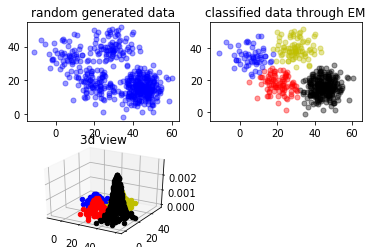

In [6]:
plotShow()